In [1]:
import lorm
from nfft import nfft
import disc.energy_curveling_so3
from pythreejs import *
from IPython.display import display
#from ipywidgets import VBox, HBox, Checkbox, jslink
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def compute_quaternions(point_coords_9d):
    point_coords_4d = np.empty([point_coords_9d.shape[0],4])
    for i,p in enumerate(point_coords_9d):
        point_coords_4d[i,:] = lorm.manif.SO3.compute_quaternion_representation(p)
    return point_coords_4d

def compute_stereographicprojection(point_coords_4d):
    point_coords_3d = np.empty([point_coords_4d.shape[0],3])
    for i,p in enumerate(point_coords_4d):
        point_coords_3d[i,:] = lorm.manif.Sphere3.compute_stereographicprojection(p)
    return point_coords_3d

In [8]:
# legendre_p_n(1/2)
int_pn = np.array([1.0,0.5,-0.125,-0.4375,-0.2890625,0.08984375,0.3232421875,0.22314453125,-0.073638916015625,-0.2678985595703125,-0.1882286071777344,0.06387138366699219,0.233752965927124,0.1658042669296265,-0.05717363953590393,-0.2100185006856918,-0.149855135474354,0.05221683974377811,0.1922962221433409,0.1377672102244105,-0.04835838106737356,-0.1784138579223509,-0.1281987246779863,0.04524493778421856,0.1671594460634509,0.1203811168693321,-0.04266414120839634,-0.1577966215046347,-0.1138384028125269,0.04047968696457777,0.1498488149006108,0.1082580079203644,-0.038599562888358,-0.1429921832522211,-0.103425075400988,0.03695911797832659,0.1369979535351437,0.09918640694089159,-0.03551142159254956,-0.1316993126940266,-0.09542943523261548,0.03422147270341801,0.1269713800411686,0.09206934414432813,-0.03306256526118129,-0.1227185621438446,-0.0890408508867776,0.03201392111450407,0.1188662759295311,0.08629277896094001,-0.03105909923960982])
# integrate(legendre_p_n(x),x,0,1)
int_pn = np.array([1., 0.5, 0., -0.125, 0., 0.0625, 0., -0.0390625, 0., 0.0273438, 0., -0.0205078, 0., 0.0161133, 0., -0.013092, 0., 0.01091, 0., -0.00927353, 0., 0.00800896, 0., -0.00700784, 0., 0.00619924, 0., -0.00553504, 0., 0.00498153, 0., -0.00451451, 0., 0.00411617, 0., -0.00377316, 0., 0.00347528, 0., -0.00321463, 0., 0.00298502, 0., -0.00278149, 0., 0.00260009, 0., -0.00243759, 0., 0.00229133, 0., -0.00215914, 0., 0.00203919, 0., -0.00192994, 0., 0.00183012, 0., -0.00173861, 0., 0.00165449, 0., -0.00157693, 0.])

In [87]:
so3 = lorm.manif.SO3()
points = lorm.manif.ManifoldPointArrayParameterized(so3)
m = 32
#points.coords = 0.3*(np.random.rand(m,3)-0.5)
points.coords = np.zeros([m,3,3])
local_coords = np.random.randn(m,3)
for i in range(m):
    local_coords[i,0] = 2*np.pi*(i+0.5)/m+(0.1*np.sin(20*np.pi*i/m))
    local_coords[i,1] = np.arccos(0.7)#np.sin(np.pi*(i+0.5)/M)
    local_coords[i,2] = 2*np.pi*(i+0.5)/m
for i in range(m):
    local_coords[i,0] = np.sin(2*np.pi*i/m)+0.25*np.cos(6*np.pi*i/m)
    local_coords[i,1] = np.arccos(0.7)#np.sin(np.pi*(i+0.5)/M)
    local_coords[i,2] = np.cos(2*np.pi*i/m)
points.local_coords = local_coords
#points.coords = 0.4*np.loadtxt('s2_4design.txt')
#points.coords = np.loadtxt('data/so3_surface_20.txt')
points_new = lorm.manif.ManifoldPointArrayParameterized(so3)

In [88]:
L = 16*2**(2./3.*0)
L /=1.08
pha=10/L**4
#disc = energy_stippling_so3.plan(M,N)
#alpha = 0.1 N = 5
#alpha = 0.0001 N = 15
m = points.coords.shape[0]
energy = disc.energy_curveling_so3.plan(m,N,alpha,L)
for n in range(np.min((N+1,len(int_pn)))):
    energy._mu_hat[n,0,0] = int_pn[n]
energy._weights = np.real(energy._mu_hat[0,0,0])* np.ones([int(m),1],dtype=float) / int(m)

#points.local_coords

In [ ]:
for k in range(4):
    N = int(np.sqrt(L*1.08))
    m = points.coords.shape[0]
    energy = disc.energy_curveling_so3.plan(m,N,10/L**4,L)
    for n in range(np.min((N+1,len(int_pn)))):
        energy._mu_hat[n,0,0] = int_pn[n]
    energy._weights = np.real(energy._mu_hat[0,0,0])* np.ones([int(m),1],dtype=float) / int(m)

    points_new.coords = np.zeros([m,2])

    print(N,m,energy._equality_constraint)
    
    method= lorm.optim.ConjugateGradientMethod(max_iter=100,tol_grad=1e-12)
    points_new.coords[:] = points.coords[:]
    for i in range(2):
        points_new = method.run(energy,points_new)
        np.savetxt("data/so3_cylinder_{}.txt")
    np.savetxt("data/tiger_{}.txt".format(k),points_new.coords)
    
    tempc = points_new.coords
    m2 = len(tempc)
    temp = np.zeros([2*m2,2])
    for i in range(m2):
        temp[2*i,:] = tempc[i,:]
    for i in range(m2-1):
        temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
    temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

    points.coords = temp
    
    


In [82]:
g1 = BufferGeometry(attributes={'position': BufferAttribute(compute_stereographicprojection(compute_quaternions(points.coords))
    , normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

scene = Scene(children=[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

<IPython.core.display.Javascript object>


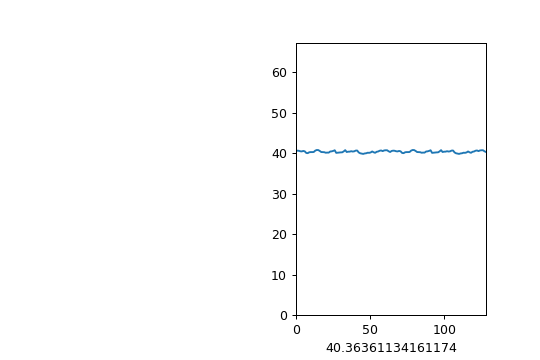

In [83]:
%matplotlib notebook
fig = plt.figure()

bx = fig.add_subplot(122)
#bx.axis(np.array([900,950,0.0045,0.0015]))
bx.axis(np.array([0,m,0.000,1.8*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.local_coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.local_coords))
bx.add_line(distance)
def update_points(p):
    g1.attributes['position'].array = compute_stereographicprojection(compute_quaternions(p.coords))
    
    distance.set_ydata(m*energy._eval_lengths(p.local_coords))
    bx.set_xlabel(np.sum(energy._eval_lengths(p.local_coords)))
    fig.canvas.draw()
    return

In [86]:
#method = lorm.optim.SteepestDescentMethod(max_iter=100)
#energy._L = 60
#energy._alpha = 3200/L**5
method = lorm.optim.ConjugateGradientMethod(max_iter=50)
method.listener = update_points 
#points_new.coords = points.coords
for i in range(1):
    points_new = method.run(energy,points_new)

Initial value: f[0] = 0.0004514565327006855
f[1] = 0.0004512358053053858
f[2] = 0.00045029495527773263
f[3] = 0.0004495212566651684
f[4] = 0.0004490360534663737
f[5] = 0.0004486324796796496
f[6] = 0.00044821325385083145
f[7] = 0.0004479066593002991
f[8] = 0.00044758240598854137
f[9] = 0.00044737637470312745
f[10] = 0.00044705094370252996
f[11] = 0.0004468586499262312
f[12] = 0.00044666582471992815
f[13] = 0.0004464753885444993
f[14] = 0.0004462947807518191
f[15] = 0.00044606864676971606
f[16] = 0.0004458977436809673
f[17] = 0.0004457253635900165
f[18] = 0.00044558710038560846
f[19] = 0.0004453969264964641
f[20] = 0.0004452201011490307
f[21] = 0.00044509566954947636
f[22] = 0.00044498335813570434
f[23] = 0.00044482511676953164
f[24] = 0.00044464750801783754
f[25] = 0.00044453405738062966
f[26] = 0.00044441093935965485
f[27] = 0.00044428532651999853
f[28] = 0.00044415583985587783
f[29] = 0.00044400955964848623
f[30] = 0.00044385653100388205
f[31] = 0.0004437352196574614
f[32] = 0.0004436

In [61]:
np.savetxt('data/so3_surface_20.txt',points_new.coords)

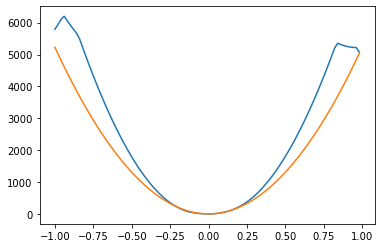

In [72]:
%matplotlib inline
v=energy.grad(points_new)
v.coords *= 10
#v.coords = 0.001*np.random.randn(m,3)
f,q, s = lorm.utils.eval_objective_function_with_quadratic_approximation(energy,v)
plt.plot(s,f,s,q)

In [80]:
tempc = points_new.coords
m2 = len(tempc)
temp = np.zeros([2*m2,9])
for i in range(m2):
    temp[2*i,:] = tempc[i,:]
for i in range(m2-1):
    temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

m = len(temp)
points.coords = temp

In [39]:
m*energy._eval_lengths(points_new.local_coords)

array([23.19139035, 23.21109831, 23.2114838 , 23.25881566, 23.48106475,
       23.59199235, 23.40824064, 23.34544319, 23.24292059, 23.06044477,
       22.99612672, 23.0888276 , 23.17058895, 23.30641966, 23.41666286,
       23.36970803, 23.29039993, 23.13498471, 23.02172649, 23.10953684,
       23.272403  , 22.97574765, 22.85889602, 22.66346974, 22.62346559,
       22.66851271, 22.82737463, 22.87877679, 23.13634004, 23.04954465,
       23.04175314, 22.99116192, 23.01245609, 23.07229353, 23.06633818,
       23.12402263, 23.08082148, 22.96717899, 22.93509329, 23.06503368,
       22.96256297, 22.90080334, 22.84801122, 22.96118156, 22.90555673,
       23.01497891, 23.09794967, 23.20794992, 23.159909  , 23.18935268,
       23.19138436, 23.21110205, 23.21148826, 23.25881404, 23.48106216,
       23.59199142, 23.40824155, 23.3454443 , 23.2429177 , 23.06044656,
       22.99613277, 23.08882481, 23.17058269, 23.3064206 , 23.41666323,
       23.36971086, 23.29040515, 23.13497985, 23.02171791, 23.10

In [30]:
20**5

3200000

In [34]:
20**5

3200000